In [136]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.stattools import acf
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [137]:
d = pd.read_csv("autre-d-aggregated.csv", delimiter=",")

In [138]:
d.head()

,date_etablissement_dpe,emission_ges
0,2013-03-26,4.502857
1,2013-03-27,6.079643
2,2013-03-28,7.656429
3,2013-03-29,9.233214
4,2013-03-30,10.810000


In [139]:
d['date_etablissement_dpe'] = pd.to_datetime(d['date_etablissement_dpe'])

In [140]:
df = d[d['date_etablissement_dpe'].between('2012-06-01','2021-06-01')]
df.set_index('date_etablissement_dpe', inplace=True)
df.head()

,emission_ges
date_etablissement_dpe,
2013-03-26,4.502857
2013-03-27,6.079643
2013-03-28,7.656429
2013-03-29,9.233214
2013-03-30,10.810000


In [141]:
dfu = d[d['date_etablissement_dpe'].between('2021-06-01','2025-06-01')]
dfu.head()

,date_etablissement_dpe,emission_ges
2989,2021-06-01,12.159821
2990,2021-06-02,8.901750
2991,2021-06-03,14.281275
2992,2021-06-04,9.436354
2993,2021-06-05,14.557797


In [142]:
scaler = MinMaxScaler(feature_range=(0, 1))

df['emission_ges_normalized'] = scaler.fit_transform(df['emission_ges'].values.reshape(-1, 1))
print(df.head())

print(len(df['emission_ges']))

                        emission_ges  emission_ges_normalized
date_etablissement_dpe                                       
2013-03-26                  4.502857                 0.127421
2013-03-27                  6.079643                 0.175685
2013-03-28                  7.656429                 0.223949
2013-03-29                  9.233214                 0.272213
2013-03-30                 10.810000                 0.320478
2990


C:\Users\maxim\AppData\Local\Temp\ipykernel_5872\4034754485.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['emission_ges_normalized'] = scaler.fit_transform(df['emission_ges'].values.reshape(-1, 1))


In [143]:
from sklearn.model_selection import train_test_split


def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 90

sequences, labels = create_sequences(df['emission_ges_normalized'].values, seq_length)

X = sequences.reshape(sequences.shape[0], sequences.shape[1], 1)
y = labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(2320, 90, 1) (580, 90, 1) (2320,) (580,)


In [144]:
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(LSTM(units=64, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.1))

model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.1))

model.add(Dense(units=1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

c:\Users\maxim\Documents\CoursCS\ST7\Projet_BNP\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 90, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [145]:
model.fit(X, y, epochs=100, batch_size=32)
'''
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
'''

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0358
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0180
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.0162
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.0165
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0176
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0176
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0175
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0160
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0167
Epoch 10/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0160
Epoch 11/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0166
Epoch 12/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0175
Epoch 13/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0180
Epoch 14/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0168
Epoch 15/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - 

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

C:\Users\maxim\AppData\Local\Temp\ipykernel_5872\1413837320.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


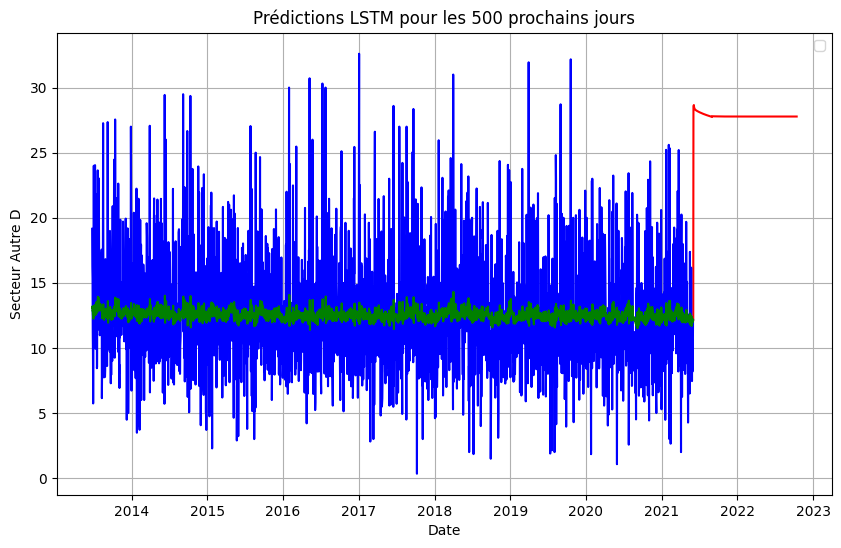

In [ ]:
def predict_next_days(model, last_sequence, days_to_predict, scaler):
    predictions = []  # Liste pour stocker les prédictions
    current_sequence = last_sequence  # Séquence initiale des derniers jours
    
    for _ in range(days_to_predict):
        # Prédire la prochaine valeur
        next_day_pred = model.predict(current_sequence)
        
        # Inverser la normalisation pour obtenir la valeur dans la gamme d'origine
        next_day_pred = scaler.inverse_transform(next_day_pred)  # Inverse transformation
        
        # Ajouter la prédiction à la liste des prédictions
        predictions.append(next_day_pred[0, 0])
        
        # Mettre à jour la séquence : ajouter la prédiction à la séquence et supprimer la plus ancienne
        current_sequence = np.append(current_sequence[:, 1:, :], next_day_pred.reshape(1, 1, 1), axis=1)
    
    return predictions

# Supposons que tu as les dernières données disponibles dans `X_train` et que `X_train` a été normalisé
# Prendre la dernière séquence des données
last_sequence = X[-1].reshape(1, X.shape[1], 1)  # (1, n_input, 1)

# Nombre de jours à prédire
days_to_predict = 500

# Prédire les 500 prochains jours
predicted_values = predict_next_days(model, last_sequence, days_to_predict, scaler)

# Créer des dates pour les 100 prochains jours
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=days_to_predict, freq='D')

# Prédire sur l'ensemble des données de test
predicted_test_values = model.predict(X)  # X_test contient les données de test préparées
predicted_test_values = scaler.inverse_transform(predicted_test_values)  # Inverse transformation



# Afficher les prédictions sur un graphique
plt.figure(figsize=(10, 6))

# Tracer les prédictions des 500 prochains jours
plt.plot(future_dates, predicted_values, color='r')

# Tracer les vraies valeurs des 500 prochains jours
#plt.plot(dfu['date_etablissement_dpe'][0:500], dfu['emission_ges'][0:500], color='y')

# Tracer les données historiques (test)
plt.plot(df.index[-len(predicted_test_values):], df['emission_ges'][-len(predicted_test_values):], color='b')

# Tracer les prédictions sur les données de test
plt.plot(df.index[-len(predicted_test_values):], predicted_test_values.flatten(), color='g')


plt.title('Prédictions LSTM pour les 500 prochains jours')
plt.xlabel('Date')
plt.ylabel('Secteur Autre D')
plt.legend()
plt.grid(True)
plt.show()